In [8]:
%matplotlib notebook


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import fastgif
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, Slider

## Numerical Integration of the paraxial propagation equation

We shall work with the following equation:
$$\frac{\partial \varepsilon}{\partial z}=\frac{i}{2k_0}  \Delta_T\varepsilon + k^2\delta\epsilon\varepsilon,  \qquad(Eq. 1)
$$
First though, we shall ignore the term due to the atmosphere, and work only in 1D:
$$
\frac{\partial \varepsilon}{\partial z}=\frac{i}{2k_0}\frac{\partial ^2 \varepsilon}{\partial x^2}
$$
Using the fourier transform technique, where epsilon is a gaussian respresented as:
$$\varepsilon(x,y)=\exp\left(-\frac{x^2+y^2}{w^2}\right) \implies \varepsilon(x) = \exp\left(-\frac{x^2}{w^2}\right)$$

We shall use the techniques described in the jupyter notebook starting with defining the gauss class

In [3]:
class Gaussian:
    """Gaussian function"""
    def __init__(self, width, amplitude, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        return self.amplitude*np.exp(-(x-self.x0)**2/self.width**2)

Now we define a class to advance the solution from $z$ to $z+\Delta z$ using the following guidelines:


This class should create the spatial $x$ and spectral $k$ grids (consider using the function numpy.fft.fftfreq), set the parameters $D = i/2k_0$, and provide a way to set the initial condition. It should also define the method  ```step(self, dz)``` for evolving $\varepsilon(x,z) \to \varepsilon(x,z+\Delta z)$. This method contains the core of the algorithm, i.e., the three substeps:

1) Transform $\varepsilon(x,z) \to \hat \varepsilon(k,z)$ using FFT

2) Advance one step $\Delta z$ using the equation:
$$ \hat \varepsilon(k,z)= \hat \varepsilon_0(k) \exp(-D k^2t ) \qquad $$
where $D=i/2k_0$
3) Transform $\hat \varepsilon(k,z) \to \varepsilon(x,z)$  using FFT$^{-1}$

In [32]:
class Spectral:
    def __init__(self, L, number_of_points, k_0):
        self.L = L
        self.number_of_points = number_of_points
        self.k_0 = k_0
        self.x_grid = np.linspace(-10*L, 10*L, number_of_points, endpoint=False)
        self.k_grid = 2 * np.pi * np.fft.fftfreq(number_of_points, d=L/number_of_points)
        self.D = 1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        if len(function) != self.number_of_points:
            raise ValueError("Function length doesn't match grid size.")
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * self.k_grid**2 * dz)
        
        self.epsilon = np.fft.ifft(epsilon_hat).real
        
        return self.epsilon

Write a function ```advance(spectral, Z, N)``` that evolves $\varepsilon(x,0) \to \varepsilon(x,Z)$ using $N$ steps

In [33]:
def advance(spectral, Z, N):
    dz = Z / N
    epsilon_evolution = []
    for _ in range(N):
        epsilon_evolution.append(spectral.step(dz))
    return np.array(epsilon_evolution)

function that gives the analytical solution to the differential equation at some $z=Z$

In [43]:
def analytical_solution(Z, D, amplitude, sigma, x_val):
    return (amplitude/np.sqrt(1+(4*D*Z/sigma**2))*np.exp(-x_val**2/(sigma**2+4*D*Z))).real

Now I shall try to match the analytical solution with the numerical solution for a variety of initial conditions, I have taken the standard deviation of the gaussian to be $L/2$, where $L$ is defined as the size of the opening and is an initial condition to solve the equation

<IPython.core.display.Javascript object>


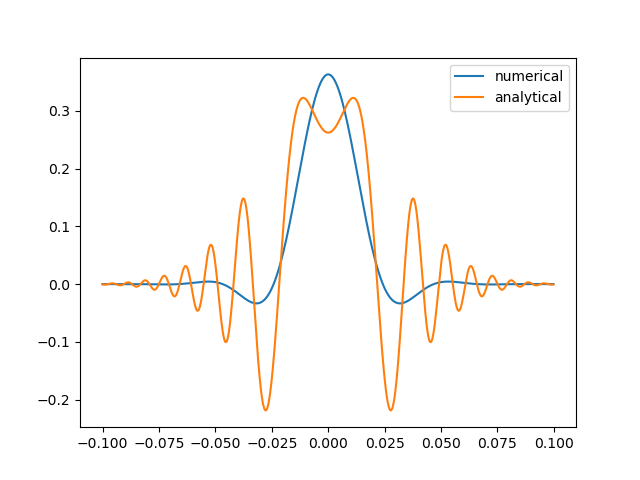

In [46]:
L = 0.01 #Which is the width of the opening of the beam
number_of_points = 2**10 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
Z = 1000 #distance of 1km
N = 100000 #numerically calculate over these many points 

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)


plt.plot(spectral.x_grid, epsilon_evolution[-1], label='numerical')
plt.plot(spectral.x_grid, analytical_solution(1000, spectral.D, 1, L/2, spectral.x_grid), label='analytical')
plt.legend()

<IPython.core.display.Javascript object>


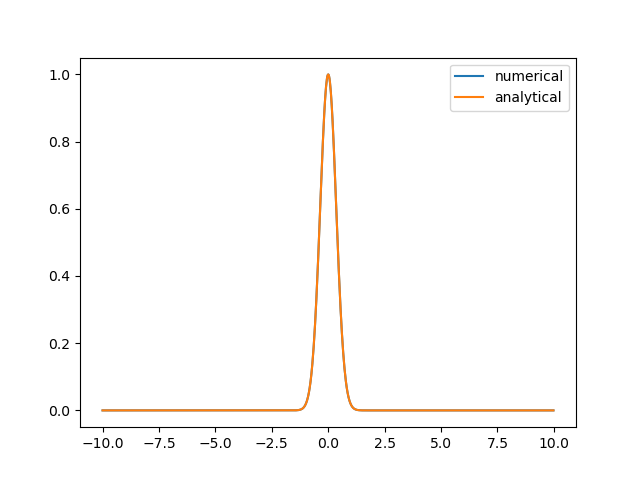

In [47]:
L = 1 #Which is the width of the opening of the beam
number_of_points = 2**10 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/635 *10**9 #red light
Z = 1000 #distance of 1km
N = 100000 #numerically calculate over these many points 

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)


plt.plot(spectral.x_grid, epsilon_evolution[-1], label='numerical')
plt.plot(spectral.x_grid, analytical_solution(1000, spectral.D, 1, L/2, spectral.x_grid), label='analytical')
plt.legend()

# It matches for L=1, and not for L=0.01

<IPython.core.display.Javascript object>


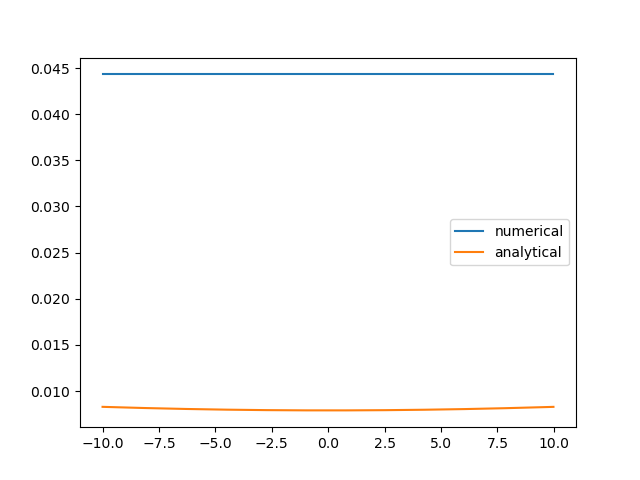

In [48]:
L = 1 #Which is the width of the opening of the beam
number_of_points = 2**10 #the number of points for the grid over which we calculate everything
k_0 = 1 #some arbitrary light
Z = 1000 #distance of 1km
N = 100000 #numerically calculate over these many points 

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)


plt.plot(spectral.x_grid, epsilon_evolution[-1], label='numerical')
plt.plot(spectral.x_grid, analytical_solution(1000, spectral.D, 1, L/2, spectral.x_grid), label='analytical')
plt.legend()

#does not match at all for light of wavelength of 2pi m

<IPython.core.display.Javascript object>


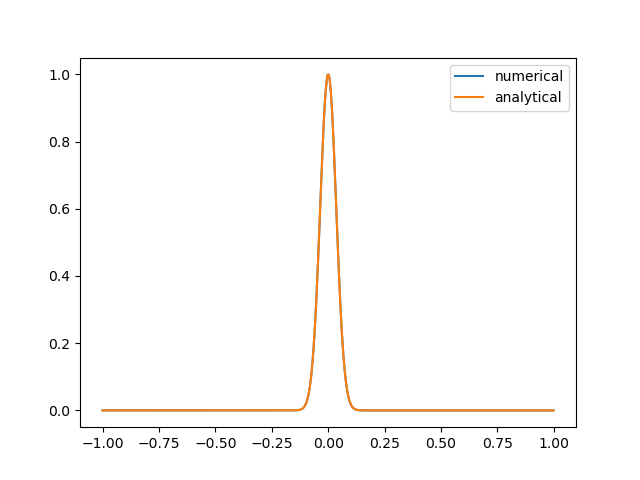

In [49]:
L = 0.1 #Which is the width of the opening of the beam
number_of_points = 2**10 #the number of points for the grid over which we calculate everything
k_0 = 2*np.pi/200 *10**9  #some arbitrary light
Z = 1000 #distance of 1km
N = 100000 #numerically calculate over these many points 

spectral = Spectral(L, number_of_points, k_0)
epsilon_initial = np.exp(- (spectral.x_grid)**2 / (L / 2)**2)  # Example initial condition
spectral.initialize(epsilon_initial)
epsilon_evolution = advance(spectral, Z, N)


plt.plot(spectral.x_grid, epsilon_evolution[-1], label='numerical')
plt.plot(spectral.x_grid, analytical_solution(1000, spectral.D, 1, L/2, spectral.x_grid), label='analytical')
plt.legend()

# matches well for light of wavelength of 200 nm and L=0.1m

So my questions are:
1. How do we know what initial conditions for the waves work?
2. For the grid of x defined in the spectral class, I chose the range (-10L, 10L) arbitrarily since it seems to give the best result. This topic is kind of vague in the instructional document. Is there a standard we should use?


Please disregard anything below here

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.imshow((epsilon_evolution.T), extent=[0, Z, -5*L, 5*L], aspect='auto', cmap='viridis')
plt.colorbar(label=r'$|\varepsilon(x,z)|$')
plt.xlabel('z')
plt.ylabel('x')
plt.title('Evolution of Epsilon')
plt.show()

In [68]:
y2 = []
for i in np.linspace(0,1,N):
    y2.append(analytical_solution(i, spectral.D, 1, L/2, spectral.x_grid))

<IPython.core.display.Javascript object>


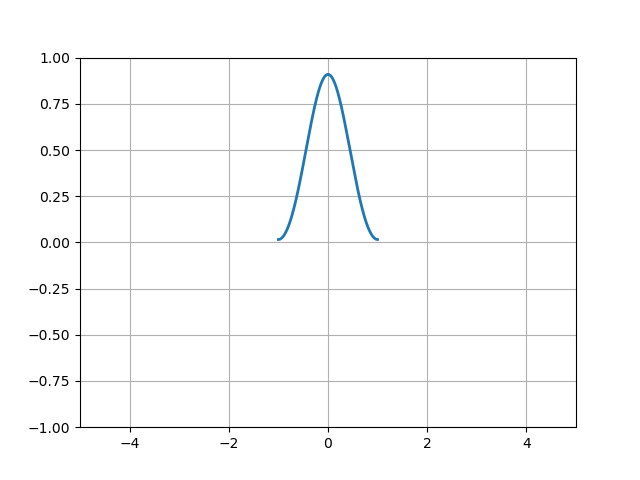

In [55]:
x_values = spectral.x_grid  # Example fixed x values
y_values_set = (epsilon_evolution)# Example epsilon_evolution (100 sets of y values)

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(-5*L, 5*L)  # Adjust xlim according to your x values
    ax.set_ylim(-1,1)   # Adjust ylim according to your y values
    return line,

def update(frame):
    y = y_values_set[frame]
    line.set_data(x_values, y)
    return line,

def update2(frame):
    y = y2[frame]
    line.set_data(x_values, y)
    return line,

# Number of frames is determined by the length of y_values_set
interval_time = 10
ani = FuncAnimation(fig, update, frames=len(y_values_set), init_func=init, blit=True, interval = interval_time)
#ani2 = FuncAnimation(fig, update2, frames=len(y2), init_func=init, blit=True, interval = interval_time)

plt.grid(True)
#ani.save('animation.mp4')
plt.show()


<IPython.core.display.Javascript object>


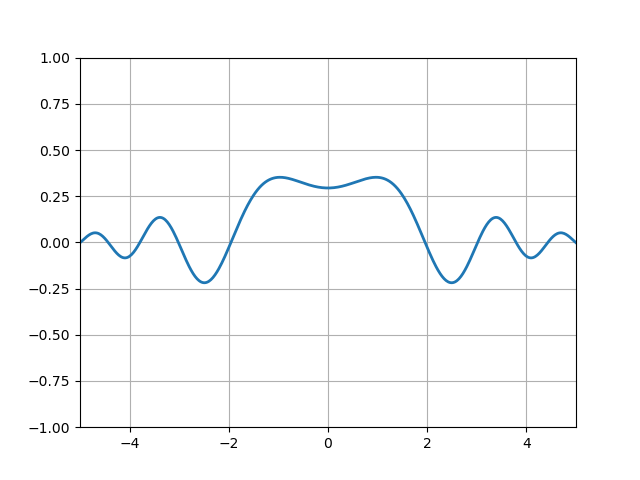

In [251]:
x_values = spectral.x_grid  # Example fixed x values
y_values_set = (epsilon_evolution)# Example epsilon_evolution (100 sets of y values)

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(-5*L, 5*L)  # Adjust xlim according to your x values
    ax.set_ylim(-1,1)   # Adjust ylim according to your y values
    return line,

def update2(frame):
    y = y2[frame]
    line.set_data(x_values, y)
    return line,

# Number of frames is determined by the length of y_values_set
interval_time = 1
ani2 = FuncAnimation(fig, update2, frames=len(y2), init_func=init, blit=True, interval = interval_time)

plt.grid(True)
#ani.save('animation.mp4')
plt.show()


<IPython.core.display.Javascript object>


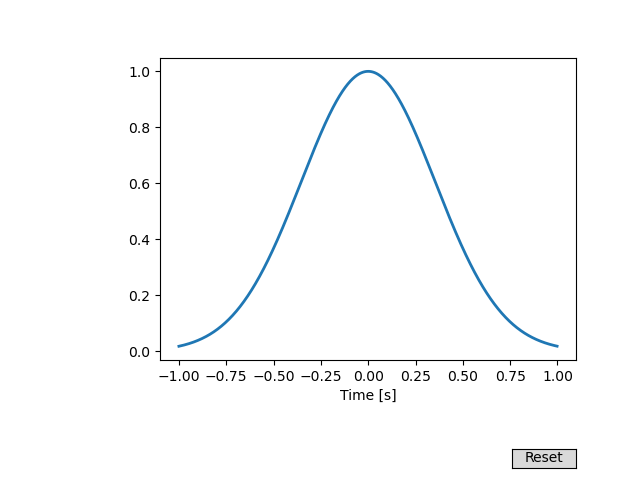

In [48]:
# The parametrized function to be plotted
def f(Z, x_val):
    return analytical_solution(Z, spectral.D, 1, L/2, x_val)

x_val = spectral.x_grid

# Define initial parameters
init_Z = 0

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(x_val, f(init_Z, x_val), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)


# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([-0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Z",
    valmin=0,
    valmax=1,
    valinit=init_Z,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(amp_slider.val, x_val))
    fig.canvas.draw_idle()


# register the update function with each slider
#freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    amp_slider.reset()
button.on_clicked(reset)

plt.show()